In [1]:
import sys
import json

general = {'step_size':'0.001', 'use_road_network':True}
catchment_radius={'bus':'500','subway':'800','rail':'1000'}

params = {
    'general': general,
    'catchment_radius':catchment_radius
    }

default = {'training_folder': '../../scenarios/base', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/base', 'params': {'general': {'step_size': '0.001', 'use_road_network': True}, 'catchment_radius': {'bus': '500', 'subway': '800', 'rail': '1000'}}}


In [2]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from typing import Literal
import numba as nb
#num_cores = 1
print('numba threads',nb.config.NUMBA_NUM_THREADS)

on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
io_engine = 'pyogrio' 

numba threads 20


In [ ]:
sys.path.insert(0, r'../../') # Add path
from utils import get_epsg, population_to_mesh, get_acf_distances, get_routing_distances

# Folders stucture and params

everything is on S3 (nothing on ECR) so no direct input folder. just scenarios/{scen}/inputs/

In [4]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(input_folder, 'model/')

In [5]:
catchment_radius = argv['params']['catchment_radius']
catchment_radius = {k:float(v) for k,v in catchment_radius.items()}
default_catchment_radius = 500

In [6]:
step_size_min = 0.0005
step_size = max(float(argv['params']['general'].get('step_size')), step_size_min)
use_road_network = argv['params']['general'].get('use_road_network')

# inputs

In [7]:
links = gpd.read_file(pt_folder + 'links.geojson',engine=io_engine) 
nodes = gpd.read_file(pt_folder + 'nodes.geojson',engine=io_engine)
links = links.set_index('index')
nodes = nodes.set_index('index')

In [8]:
population_file = os.path.join(input_folder, 'population.geojson')
population_file_provided = os.path.isfile(population_file)
if population_file_provided :
    population = gpd.read_file(population_file, engine=io_engine)
    if 'index' in population.columns:
        population = population.set_index('index')
    else:
        population.index.name='index'
    assert 'density' in population.columns, 'need density column. in km2'
    assert population.crs == 4326, 'population.geojson CRS must be EPSG:4326'
print('population?',population_file_provided)

population? True


# Formation :
 ajouter un paramètre pour utiliser le réseau routier ou non. <br>
 Dans le modèle actuelle, le réseau routier est automatiquement utilisé pour :
 * faire un mesh de la population (affecter les gens aux noeds du réseau)
 * évaluer le stop catchment (la distance de routing est utilisé pour le catchment_radius)

 On pourrait ne pas vouloir utiliser le réseau meme si il est dans le projet! <br>
 TODO: changer rnodes_file_provided pour une combinaison entre un parametre et l'existance du fichier

In [9]:
rnodes_file = os.path.join(road_folder, 'road_nodes.geojson')
rnodes_file_provided = os.path.isfile(rnodes_file)
if rnodes_file_provided:
    rnodes = gpd.read_file(os.path.join(road_folder, 'road_nodes.geojson'), engine=io_engine)
    rnodes = rnodes.set_index('index')
    rlinks = gpd.read_file(os.path.join(road_folder, 'road_links.geojson'), engine=io_engine)
    rlinks = rlinks.set_index('index')
print('rnodes?',rnodes_file_provided)

rnodes? False


In [10]:
od_file = os.path.join(od_folder, 'od.geojson')
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_file, engine=io_engine)
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
print('od?',od_file_provided)

od? True


# population preparation

In [11]:
# find meters CRS
centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
crs = get_epsg(centroid[1],centroid[0])
crs

C:\Users\mlaune\AppData\Local\Temp\ipykernel_21132\550055817.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = [*LineString(nodes.centroid.values).centroid.coords][0]


32618

In [12]:
if population_file_provided : 
    population['area (km2)'] = population.to_crs(crs).area*1e-6
    population['area (km2)'].sum()

In [13]:
if population_file_provided :
    population['population'] = population['density']*population['area (km2)']
    population['population'].sum()

# population mesh

# Formation :
Ajouter step comme parametre pour controler le step size <br>
peut-etre avoir une limite pour ne pas crash le code si step_size est trop petit <br>
step est en degrés (0.0025 ~250m)

In [14]:
if not population_file_provided:
    mesh = gpd.GeoDataFrame(index=[0],data={'zone':'centroid','population':0},geometry=[Point(centroid[0],centroid[1])])
    mesh.index.name = 'index'
    mesh.crs=4326
    if rnodes_file_provided and use_road_network:
        mesh['node_index'] = rnodes.index[0]
elif rnodes_file_provided and use_road_network:
    # use rnodes as mesh.
    print('using road_nodes')
    mesh = population_to_mesh(population, mesh=rnodes, step=step_size, col='population', fill_missing='nearest')
else:
    # create a mesh
    #0.01 = 1km 0.005 = 500m
    mesh = population_to_mesh(population, step=step_size, col = 'population', fill_missing='centroid')

185998 nodes in multiple zones. will be match to a single zone.
3 unfounded zones
Unfound zones centroid will be added to mesh


In [15]:
mesh.to_file(output_folder + 'population_mesh.geojson',driver='GeoJSON',engine=io_engine)

# catchment

In [16]:
# find TC nodes to mesh distance

In [17]:
max_dist = max(max(catchment_radius.values()),default_catchment_radius)

In [18]:
if rnodes_file_provided:
    print('using road_nodes')
    node_dist = get_routing_distances(nodes, rnodes, rlinks, mesh, 'length', max_dist)
else:
    node_dist = get_acf_distances(nodes, mesh, crs, max_dist)

# metrics

In [19]:
print('num route_id:',len(links['route_id'].unique()))
print('num route_type:',len(links['route_type'].unique()))

num route_id: 623
num route_type: 3


In [20]:
#init results dfs
df_route_id = pd.DataFrame(index=links['route_id'].unique())
df_route_id.index.name='route_id'

df_route_type = pd.DataFrame(index=links['route_type'].unique())
df_route_type.index.name='route_type'

In [21]:

def get_catchment(col='route_id'):
    #get all nodes with col filter
    link = links.groupby(col)[['a','b','route_type']].agg({'a':set,'b':set,'route_type':'first'})
    link['node'] = link.apply(lambda row: row['a'].union(row['b']), axis=1)
    link = link.drop(columns=['a','b'])
    # add catchment radius for the route_type
    link['catchment_radius'] = link['route_type'].apply(lambda x: catchment_radius.get(x,default_catchment_radius))

    col_exist = col == 'route_type' # cannot explode if index == route_type (a column)
    link = link.explode('node').reset_index(drop=col_exist)
    link = node_dist.merge(link, left_on='node_index', right_on='node')
    #filter by distance
    link = link[link['distances'] <= link['catchment_radius']]
    #drop duplicated mesh nodes (we count only one time)
    link = link.drop_duplicates(subset=['mesh_index',col],keep='first')

    return link.groupby(col)['population'].sum().to_dict()
    

In [22]:
res = get_catchment('route_id')

df_route_id['catchment'] = res
df_route_id['catchment'] = df_route_id['catchment'].fillna(0) 
print(sum([item for key,item in res.items()]))


20512663.45264404


In [23]:
res = get_catchment('route_type')

df_route_type['catchment'] = res
df_route_type['catchment'] = df_route_type['catchment'].fillna(0) 

print(sum([item for key,item in res.items()]))

4949632.886172468


# frequency

In [24]:
links['frequency'] = 1/links['headway']

In [25]:
res = (links.groupby('route_id')['frequency'].agg('mean')*3600).to_dict()

df_route_id['frequency (veh/hours)'] = res
print(np.nansum([item for key,item in res.items()]))

1425.054379138755


In [26]:
res = (links.groupby('route_type')['frequency'].agg('mean')*3600).to_dict()

df_route_type['frequency (veh/hours)'] = res
print(sum([item for key,item in res.items()]))

17.213400791483306


In [27]:
link = (links.groupby(['route_id','trip_id'])[['frequency']].agg('mean')*3600)
res = link.reset_index().set_index('route_id')['frequency'].to_dict()
print(np.nansum([item for key,item in res.items()]))

1214.8641138404555


In [28]:
link = (links.groupby(['route_type','trip_id'])[['frequency']].agg('mean')*3600)
res = link.reset_index().set_index('route_type')['frequency'].to_dict()
print(np.nansum([item for key,item in res.items()]))

16.354150816251114


# operational Fleet

In [29]:
def get_fleet(col='route_id'):
    link = links.groupby([col,'trip_id'])[['time','frequency']].agg({'time':'mean','frequency':'mean'})
    link['fleet'] = np.ceil(link['frequency'] * link['time'])
    return link.reset_index().groupby(col)['fleet'].agg('sum').to_dict()
    

In [30]:
res = get_fleet('route_id')

df_route_id['fleet'] = res
print(sum([item for key,item in res.items()]))

1157.0


In [31]:
res = get_fleet('route_type')

df_route_type['fleet'] = res
print(sum([item for key,item in res.items()]))

1157.0


# Line Length

In [32]:
def get_length(col='route_id',length_col='length'):
    link = links.groupby([col,'trip_id'])[[length_col]].agg('sum')
    return link.reset_index().groupby(col)[length_col].agg('sum').to_dict()
    

In [33]:
# preparation. if length is NaN, or if shape dist travel exist.

length_col = None
if 'length' in links.columns and length_col == None:
    if len(links[links['length'].isnull()])==0:
        length_col = 'length'
        
if 'shape_dist_traveled' in links.columns and length_col == None:
    if len(links[links['shape_dist_traveled'].isnull()])==0:
        length_col = 'shape_dist_traveled'

if length_col == None:
    print('create length from geometry')
    links['length'] = links.to_crs(crs).length
    length_col = 'length'


In [34]:
res = get_length('route_id',length_col)

df_route_id['length (m)'] = res
print(sum([item for key,item in res.items()]))

18244962


In [35]:
res = get_length('route_type',length_col)

df_route_type['length (m)'] = res
print(sum([item for key,item in res.items()]))

18244962


# Number of station per line

In [36]:
# o-->o-->o-->o and  o<--o<--o<--o
# est-ce que j'ai 8 ou 4 stations ?
# j'ai 4 stations par trip et 4 stations par route (si c'est les memes).
# comment savoir si cest les memes. clustering?
# pour linstant. on prend tous les noeds unique par route_id ou route_type (col='route_id', route_id)
def get_num_station(col='route_id'):
    link = links.groupby(col)[['a','b']].agg({'a':set,'b':set})
    link['node_len'] = link.apply(lambda row: len(row['a'].union(row['b'])), axis=1)
    return link['node_len'].to_dict()


In [37]:
res = get_num_station('route_id')

df_route_id['num station'] = res
print(sum([item for key,item in res.items()]))

39380


In [38]:
res = get_num_station('route_type')

df_route_type['num station'] = res
print(sum([item for key,item in res.items()]))

39325


# Vehicle revenue KM 

In [39]:
def get_veh_kmh(col='route_id'):
    link = links.groupby([col,'trip_id'])[[length_col,'frequency']].agg({length_col:'sum','frequency':'mean'})
    link['veh_km/h'] = np.ceil(link['frequency'] * link[length_col]) * 3600/1000 #to km/H
    return link.reset_index().groupby(col)['veh_km/h'].agg('sum').to_dict()

In [40]:
res = get_veh_kmh('route_id')

df_route_id['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

38214.000000000044


In [41]:
res = get_veh_kmh('route_type')

df_route_type['veh.km/h'] = res
print(sum([item for key,item in res.items()]))

38214.0


# Round trip time

In [42]:
def get_round_trip_time(col='route_id'):
    link = links.groupby([col,'trip_id'])[['time']].agg('sum')
    return link.reset_index().groupby(col)['time'].agg('sum').to_dict()
    

In [43]:
res = get_round_trip_time('route_id')

df_route_id['round trip time (s)'] = res
print(sum([item for key,item in res.items()]))

2417186


# export dfs to csv

In [44]:
# round numbers
for col in ['catchment', 'frequency (veh/hours)','length (m)','veh.km/h','round trip time (s)']:
    df_route_id[col] = df_route_id[col].apply(lambda x :np.round(x,2))
    df_route_id[col] = df_route_id[col].apply(lambda x :np.round(x,2))


In [45]:
#df_route_id = df_route_id.fillna('null')
#df_route_type = df_route_type.fillna('null')

In [46]:
df_route_id.to_csv(output_folder+'route_id_metrics.csv')
df_route_id

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h,round trip time (s)
route_id,,,,,,,
CITCRC_10,7220.40,7.71,1.0,3808,16,32.4,600
CITCRC_11,7604.36,4.36,1.0,5461,21,25.2,840
CITCRC_12,8994.67,4.36,1.0,8279,32,39.6,1140
CITCRC_13,5114.07,4.02,1.0,7718,25,32.4,1080
CITCRC_14,9614.25,1.34,1.0,13117,43,18.0,1800
...,...,...,...,...,...,...,...
TRAINS_6,200595.19,0.84,2.0,94784,24,82.8,8694
STM_1,262448.84,17.78,2.0,40132,54,716.4,4450
STM_2,358457.03,11.91,3.0,80397,90,979.2,8127


In [47]:
df_route_type.to_csv(output_folder+'route_type_metrics.csv')
df_route_type

,catchment,frequency (veh/hours),fleet,length (m),num station,veh.km/h
route_type,,,,,,
bus,3.616980e+06,2.200035,1133.0,17534251,38981,35600.4
rail,6.616541e+05,0.938547,15.0,563542,170,547.2
subway,6.709991e+05,14.074818,9.0,147169,174,2066.4


# Formation:

exporter une image (.png) <br>
ex: barplot du catchement pour les route_type

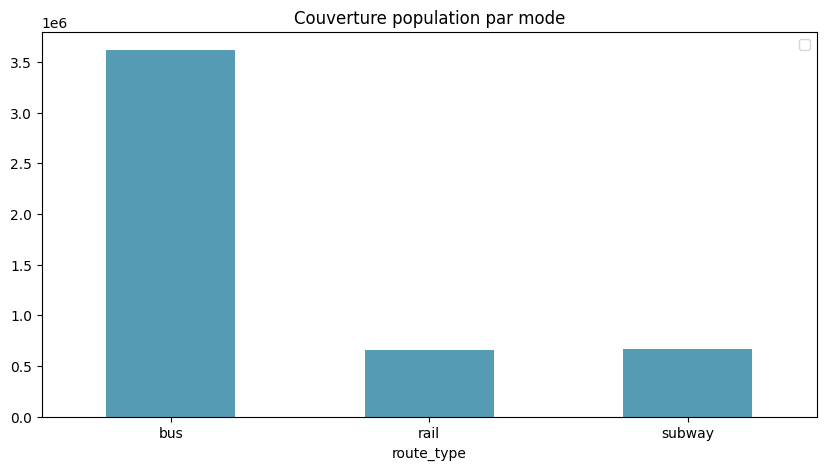

In [48]:
plot = df_route_type.reset_index().plot(kind='bar', x='route_type', y='catchment', color='#559bb4', rot=0, figsize=[10, 5])
plot.set_title('Couverture population par mode')
plot.set_ylabel('')
plot.set_xlabel("route_type")
plot.legend([])

# geomatic outputs

In [48]:
#using get catchment. get the catchment radius of each node (get larger one if used by many mode.)
link = links.groupby('route_type')[['a','b','route_type']].agg({'a':set,'b':set,'route_type':'first'})
link['node'] = link.apply(lambda row: row['a'].union(row['b']), axis=1)
link = link.drop(columns=['a','b'])
# add catchment radius for the route_type
link['catchment_radius'] = link['route_type'].apply(lambda x: catchment_radius.get(x,default_catchment_radius))
link = link.explode('node').reset_index(drop=True)
link = link.sort_values('catchment_radius',ascending=False).drop_duplicates('node',keep='first')
link = node_dist.merge(link, left_on='node_index', right_on='node')
link = link[link['distances'] <= link['catchment_radius']]

temp_dict = link.groupby('node_index')['population'].sum().to_dict()
nodes['catchment'] = nodes.index.map(temp_dict.get)

temp_dict = link.groupby('node_index')['catchment_radius'].agg('first').to_dict() 
nodes['catchment_radius'] = nodes.index.map(temp_dict.get)


In [49]:
nodes.to_file(output_folder+'nodes.geojson',driver='GeoJSON',engine=io_engine)

# test